<h1 align="center">An Introduction to Machine Learning - 25737</h1>
<h4 align="center">Dr. Yasaei</h4>
<h4 align="center">Sharif University of Technology, Autumn 2024</h4>

**Student Name**: fariborz kohanzad 

**Student ID**: 400103613

# Gaussian Mixture Models with EM

## Introduction and Purpose

In this exercise, you will:

1. Implement a **Gaussian Mixture Model (GMM)** using the Expectation-Maximization (EM) algorithm **from scratch** (using NumPy and basic Python operations).
2. Implement the **same GMM model using PyTorch**.
3. Compare and contrast the two implementations (performance, complexity, ease of coding, etc.).

**Gaussian Mixture Models** assume that data is generated from a mixture of several Gaussian distributions. The EM algorithm iteratively updates the parameters (means, covariances, and mixture weights) of these Gaussians to maximize the likelihood of observed data.



## Part 1: Data Loading and Exploration

**Tasks:**  
- Load the Iris dataset and store the features in `X` and labels in `y`.
- Print the shape of `X` and examine a few rows.
- **Hint:** Use `sklearn.datasets.load_iris()` to load the data.

In [1]:
# TODO: Load the Iris dataset and print shape
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

print("Shape of X:", X.shape)
print("First 5 samples:\n", X[:5])


Shape of X: (150, 4)
First 5 samples:
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


## Part 2: Data Preprocessing (Scaling)

**Tasks:**  
- Scale the data using `StandardScaler` so that each feature has zero mean and unit variance.
- **Hint:** `from sklearn.preprocessing import StandardScaler`.


In [2]:
# TODO: Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Mean after scaling:", X_scaled.mean(axis=0))
print("Std after scaling:", X_scaled.std(axis=0))

Mean after scaling: [-1.69031455e-15 -1.84297022e-15 -1.69864123e-15 -1.40924309e-15]
Std after scaling: [1. 1. 1. 1.]


## Part 3: Implementing GMM with EM **from scratch** (NumPy-based)

We will first implement GMM using NumPy arrays and basic operations, without PyTorch.

**Tasks:**  
- Choose the number of components `K` (e.g., K=3).
- Initialize the parameters: means, covariances (diagonal), and mixture weights.
- Write functions for the E-step and M-step of the EM algorithm.
- Run the EM algorithm for a fixed number of iterations.

**Hints for Implementation:**

- Means: K x D array.
- Covariances: K x D x D (diagonal only, so you mainly store variances per feature).
- Weights: K-dimensional array, summing to 1.
- To compute Gaussian densities, recall the formula for the probability density of a multivariate Gaussian.
- For the E-step, compute responsibilities using the mixture components and their densities.
- For the M-step, update means, covariances, and weights using the responsibilities.

After implementing and running EM, extract cluster assignments by taking `argmax` of responsibilities.


In [3]:
import numpy as np

K = 3  # number of Gaussian components
N, D = X_scaled.shape

# Seed for reproducibility (optional)
np.random.seed(42)


# Means: shape (K, D)
means = np.random.randn(K, D)

# shape (K, D)
covariances = np.ones((K, D))

# Mixture weights (K-dimensional), must sum to 1
weights = np.ones(K) / K


def gaussian_pdf(X, mean, cov_diag):
    D = X.shape[1]
    eps = 1e-6

    cov_diag_safe = cov_diag + eps
    norm_constant = (1.0 / np.sqrt((2 * np.pi) * cov_diag_safe)).prod()
    exponent = -0.5 * np.sum(((X - mean) ** 2) / cov_diag_safe, axis=1)

    pdf_values = norm_constant * np.exp(exponent)
    return pdf_values


def e_step(X, means, covariances, weights):
    N = X.shape[0]
    K = means.shape[0]

    unnormalized = np.zeros((N, K))

    for k in range(K):
        pdf_k = gaussian_pdf(X, means[k], covariances[k])
        unnormalized[:, k] = weights[k] * pdf_k

    row_sums = unnormalized.sum(axis=1, keepdims=True)

    row_sums[row_sums == 0] = 1e-12

    responsibilities = unnormalized / row_sums
    return responsibilities


def m_step(X, responsibilities):
    N, D = X.shape
    Nk = responsibilities.sum(axis=0)  # shape (K,)
    new_weights = Nk / N

    new_means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]

    new_covariances = np.zeros((K, D))
    for k in range(K):
        # X - mu_k
        diff = X - new_means[k]
        # Weighted sum of squared diffs (across N), for each dimension
        weighted_sum_sq = np.dot(responsibilities[:, k], diff ** 2)
        # Diagonal variances
        new_covariances[k] = weighted_sum_sq / Nk[k]

    return new_means, new_covariances, new_weights

num_iterations = 20
for iteration in range(num_iterations):
    # E-step
    responsibilities = e_step(X_scaled, means, covariances, weights)

    # M-step
    means, covariances, weights = m_step(X_scaled, responsibilities)

# After EM converges (or max iterations), get cluster assignments
cluster_labels_numpy = responsibilities.argmax(axis=1)

print("Final means (shape: K x D):\n", means)
print("Final diagonal covariances (shape: K x D):\n", covariances)
print("Final weights (shape: K, sums to 1):\n", weights)
print("Cluster assignments (first 10):", cluster_labels_numpy[:10])


Final means (shape: K x D):
 [[ 1.14953211  0.01866289  1.10691507  1.18302783]
 [ 0.09748721 -0.71076475  0.36253638  0.27294148]
 [-1.01457897  0.85326268 -1.30498732 -1.25489349]]
Final diagonal covariances (shape: K x D):
 [[0.42874164 0.43718668 0.08281989 0.10669686]
 [0.34135525 0.46528234 0.08838831 0.11627815]
 [0.17876968 0.74619175 0.00954805 0.01885874]]
Final weights (shape: K, sums to 1):
 [0.25968617 0.40698049 0.33333333]
Cluster assignments (first 10): [2 2 2 2 2 2 2 2 2 2]


## Part 4: Implementing GMM with EM **using PyTorch**

Now, we will implement the same algorithm using PyTorch tensors. The steps are similar, but you will use `torch` operations. This might simplify certain operations and open the door to GPU acceleration.

**Tasks:**  
- Convert `X_scaled` to a PyTorch tensor.
- Initialize parameters as `torch.tensor`s.
- Implement E-step and M-step in PyTorch.
- Run EM for a fixed number of iterations.
- Extract cluster labels.

**Hints:**
- Use `torch.tensor(X_scaled, dtype=torch.float32)` to create a PyTorch tensor.
- Operations are similar but use `torch.sum`, `torch.exp`, etc.
- Watch out for broadcasting rules and ensure shapes align.


In [4]:
import torch

X_torch = torch.tensor(X_scaled, dtype=torch.float32)

N, D = X_torch.shape
K = 3  # number of components

torch.manual_seed(42)


means_torch = torch.randn(K, D, dtype=torch.float32)
covariances_torch = torch.ones(K, D, dtype=torch.float32)
weights_torch = torch.ones(K, dtype=torch.float32) / K


def gaussian_pdf_torch(X, mean, cov_diag):
    eps = 1e-6
    cov_diag_safe = cov_diag + eps

    D_ = X.shape[1]
    denom = torch.sqrt(2.0 * torch.pi * cov_diag_safe).prod()
    exponent = -0.5 * torch.sum(((X - mean) ** 2) / cov_diag_safe, dim=1)

    pdf_values = (1.0 / denom) * torch.exp(exponent)
    return pdf_values


def e_step_torch(X, means, covariances, weights):
    N = X.shape[0]
    K = means.shape[0]

    unnormalized = []
    for k in range(K):
        pdf_k = gaussian_pdf_torch(X, means[k], covariances[k])
        unnormalized_k = weights[k] * pdf_k
        unnormalized.append(unnormalized_k)

    # Stack to shape (K, N) => transpose to (N, K)
    unnormalized = torch.stack(unnormalized, dim=0).T

    # Normalize across k
    row_sums = torch.sum(unnormalized, dim=1, keepdim=True)
    # Avoid division by zero
    row_sums = torch.clamp(row_sums, min=1e-12)

    responsibilities = unnormalized / row_sums
    return responsibilities


def m_step_torch(X, responsibilities):
    N, D = X.shape
    # sum of responsibilities for each component
    Nk = torch.sum(responsibilities, dim=0)  # (K,)

    # updated weights
    new_weights = Nk / N

    new_means = (responsibilities.T @ X) / Nk.unsqueeze(1)

    # updated diagonal covariances
    new_covariances = []
    for k in range(responsibilities.shape[1]):
        diff = X - new_means[k]
        weighted_sum_sq = torch.sum(responsibilities[:, k].unsqueeze(1) * (diff ** 2), dim=0)
        var_k = weighted_sum_sq / Nk[k]
        new_covariances.append(var_k)
    new_covariances = torch.stack(new_covariances, dim=0)  # (K, D)

    return new_means, new_covariances, new_weights


num_iterations = 20
for iteration in range(num_iterations):
    # E-step
    responsibilities_torch = e_step_torch(X_torch, means_torch, covariances_torch, weights_torch)

    # M-step
    means_torch, covariances_torch, weights_torch = m_step_torch(X_torch, responsibilities_torch)

# Extract cluster assignments
cluster_labels_torch = torch.argmax(responsibilities_torch, dim=1)

print("Final means (K x D):\n", means_torch)
print("Final diagonal covariances (K x D):\n", covariances_torch)
print("Final weights (K, sums to 1):\n", weights_torch)
print("Cluster assignments (first 10):", cluster_labels_torch[:10])


Final means (K x D):
 tensor([[-1.0146,  0.8533, -1.3050, -1.2549],
        [-0.0709, -0.8744,  0.2368,  0.1161],
        [ 0.9259, -0.1024,  0.9535,  0.9977]])
Final diagonal covariances (K x D):
 tensor([[0.1788, 0.7462, 0.0095, 0.0189],
        [0.3064, 0.4387, 0.0675, 0.0576],
        [0.4618, 0.4335, 0.1112, 0.1655]])
Final weights (K, sums to 1):
 tensor([0.3333, 0.2800, 0.3867])
Cluster assignments (first 10): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## Part 5: Evaluating and Comparing Both Implementations

**Tasks:**  
- Use `adjusted_rand_score` to compare the cluster labels from both methods against the true labels `y`.
- Print the ARI for both NumPy and PyTorch implementations.
- Visually inspect if both implementations yield similar results.

**Questions:**
- Are the ARI scores similar or different between the two implementations?
- Which code was easier to write and maintain?
- Which implementation might be easier to extend to more complex models?


In [5]:
from sklearn.metrics import adjusted_rand_score

# TODO: Compute ARI for numpy-based clustering
ari_numpy = adjusted_rand_score(y, cluster_labels_numpy)
print("ARI (NumPy):", ari_numpy)

# TODO: Compute ARI for torch-based clustering
ari_torch = adjusted_rand_score(y, cluster_labels_torch)
print("ARI (PyTorch):", ari_torch)


ARI (NumPy): 0.7445264308738749
ARI (PyTorch): 0.7868729885244303


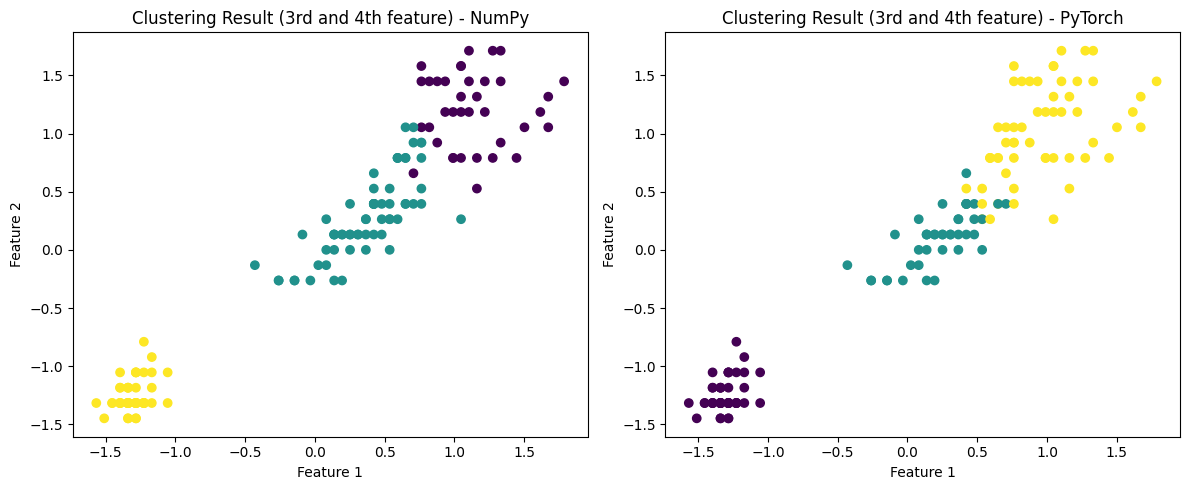

In [10]:
import matplotlib.pyplot as plt

# Suppose X_scaled is (N, 2) for illustration
plt.figure(figsize=(12, 5))

# Subplot 1: NumPy-based labels
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 2], X_scaled[:, 3], c=cluster_labels_numpy, cmap='viridis')
plt.title("Clustering Result (3rd and 4th feature) - NumPy")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Subplot 2: PyTorch-based labels
plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 2], X_scaled[:, 3], c=cluster_labels_torch, cmap='viridis')
plt.title("Clustering Result (3rd and 4th feature) - PyTorch")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()


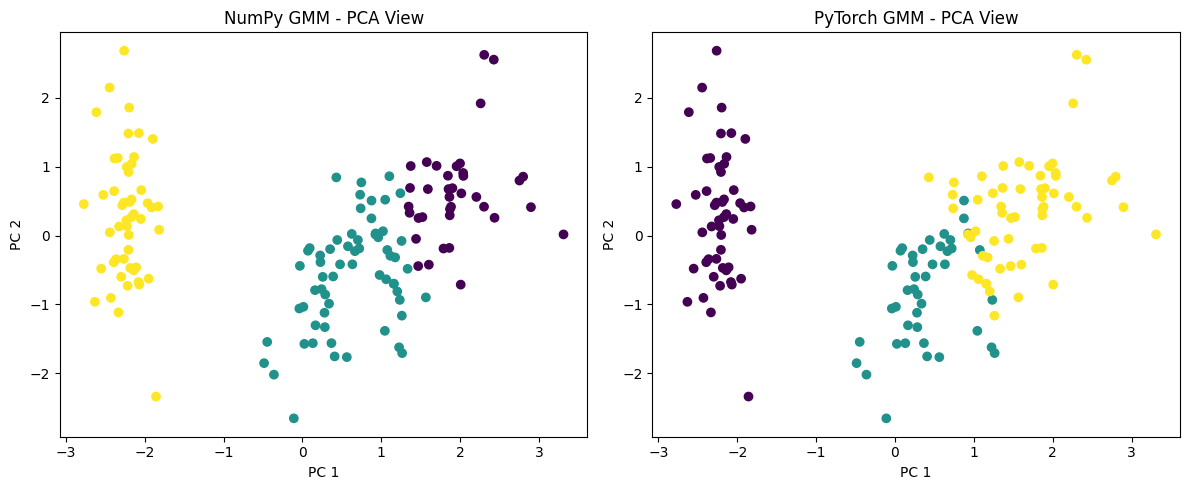

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# NumPy-based clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_numpy, cmap='viridis')
plt.title("NumPy GMM - PCA View")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# PyTorch-based clusters
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_torch, cmap='viridis')
plt.title("PyTorch GMM - PCA View")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.tight_layout()
plt.show()


**Answers:**
- Are the ARI scores similar or different between the two implementations?
  
  - They are almost equal, with the Pytorch implementation having a slight edge.

- Which code was easier to write and maintain?

   - the Pytorch code was easier due to its readily avaiable methods.

- Which implementation might be easier to extend to more complex models?

    - From a practical standpoint, **PyTorch** tends to be easier to extend to more complex models. While the NumPy-based approach is great for learning the fundamentals and having tight control over every step, PyTorch offers:

    1. **Autograd**: Automatic differentiation, which is particularly useful if you start mixing your GMM with neural networks or other learnable components.
    
    2. **GPU Acceleration**: Straightforward device (CPU/GPU) management, which becomes crucial when your data or model size grows.
    
    3. **Integration**: PyTorch’s ecosystem (e.g., `torch.nn`, `torch.distributions`, and community libraries) makes it simpler to incorporate more advanced layers, custom losses, and training loops.

**Questions:**  
1. **Implementation Detail:** What are the main differences in code complexity between a plain NumPy-based implementation and a PyTorch-based one?  
answer:

    - **NumPy**: You write everything from scratch—Gaussian PDF calculations, loops for the E-step, M-step, etc. This can be more verbose but also educational, as you see exactly how each step is done.  
    - **PyTorch**: You use tensors and PyTorch operations. The code looks similar in structure, but you replace NumPy functions with torch equivalents (`torch.sum`, `torch.exp`, etc.). In principle, the EM algorithm remains the same, but managing device (CPU/GPU) placement and tensor operations can add some overhead or require additional care.


2. **Performance:** Which implementation is likely to be more efficient or easier to parallelize and why?  
answer:

    - **PyTorch** is generally *easier to parallelize* and can leverage GPU acceleration out of the box. For larger datasets or high-dimensional data, moving computations to a GPU can significantly speed up performance. NumPy can be efficient on CPU (due to underlying BLAS/LAPACK optimizations), but parallelizing or using a GPU often requires additional libraries or setups (e.g., CuPy). PyTorch has that capability built-in, so it’s more straightforward to scale up.


3. **Numerical Stability:** How might PyTorch’s built-in functions improve numerical stability compared to a manual implementation?  
answer:

    - **PyTorch** provides many built-in functions (like `torch.logsumexp`, `torch.distributions`, etc.) that handle potential overflow or underflow internally. It also allows for automatic differentiation, which can sidestep some mistakes in manual derivatives. In contrast, a pure NumPy implementation might require you to manually inject small values for numerical stability (e.g., `1e-6` in the diagonal of covariance, or checks to avoid dividing by zero). While you can still be stable in NumPy, PyTorch’s library routines often come with careful handling of edge cases.

4. **Extendability:** If you wanted to add more complex features (e.g., full covariance matrices, regularization), which approach would be simpler and why?
answer:

    - **PyTorch** is typically *simpler to extend* when adding complexity, such as:
      - Using full covariance matrices instead of diagonal ones.
      - Adding regularization terms or constraints.
      - Mixing GMM components with neural networks or more advanced architectures.  

    This is because you can leverage PyTorch’s autograd for gradient-based optimization, integrate with existing neural network modules, and run on GPU seamlessly. In contrast, a pure NumPy implementation might be clearer for learning, but you’ll need more manual work to handle derivatives, advanced optimization, or GPU acceleration.
